# Data Analysis

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import diplomatic_exchanges as de

In [2]:
# create a plots folder to store plots
import os
if not os.path.exists('./plots/'):
    os.mkdir('./plots')
if not os.path.exists('./plots/results'):
    os.mkdir('./plots/results')
    

# Get data for 2005

In [3]:
# run query to get data for regression analysis from database
conn = sqlite3.connect('diplomatic.db')
data = de.get_data_for_regression(conn, 2005)

In [4]:
# use a binary variable signifying whether the US president visited each country or not
# 1: the president visited
# 0: the president did NOT visit
data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)

In [5]:
# example dataset
data.head(4)

,index,pagerank,katz,eigenvector,betweenness,closeness,degree,in_degree,out_degree,node_id,...,year,milex,milper,irst,pec,tpop,upop,cinc,version,president_visit_binary
0,24,1.000000,0.966833,0.348819,5.160641e-13,1.0,1.000000,0.948718,1.000000,2,...,2005,495326000,1474,94897,3267376,298166.0,164533.0,0.156302,2021,0
1,48,0.521256,0.804169,0.466178,7.604882e-13,1.0,0.741379,0.621795,0.701754,20,...,2005,13224000,62,15327,370302,32253.0,18647.0,0.010920,2021,1
2,73,0.014564,0.033838,0.551500,9.068511e-37,1.0,0.022989,0.025641,0.017544,31,...,2005,36000,1,0,266,329.0,0.0,0.000025,2021,0
3,1615,0.407570,0.609600,0.616611,6.781469e-09,1.0,0.528736,0.564103,0.415205,40,...,2005,1444000,49,245,12063,11292.0,2927.0,0.001351,2021,0


## compute GDP per capita

In [6]:
# compute gdp per capita
data['per_capita'] = data['rgdpna']/data['pop']
data['per_capita'].head(10)

0    54449.451941
1    45565.692084
2    35576.570576
3             NaN
4     1574.206085
5     9945.891176
6     8476.961664
7    24193.637657
8    11799.938776
9     9091.544015
Name: per_capita, dtype: float64

In [7]:
# there are some values missing from the Pennworld table dataset
sum(data["per_capita"].isna())

28

In [8]:
# we decide to drop them since they correspond to a small number of countries
data = data[data["per_capita"].notna()]
data

In [10]:
import seaborn as sns

Text(0.5, 1.0, 'Correlation coefficients, year 2005')

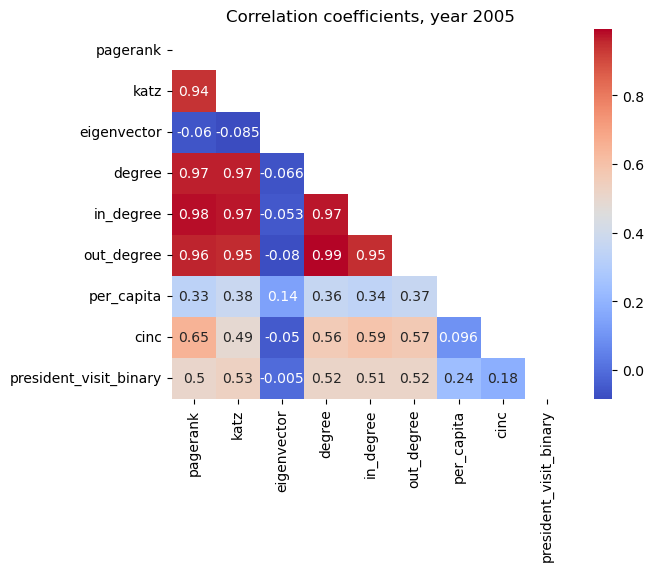

In [13]:
# check for correlation between measures
columns_for_heatmap = ['pagerank', 'katz', 'eigenvector', 'degree', 'in_degree', 'out_degree', 'per_capita', 'cinc', 'president_visit_binary']

correlations = data[columns_for_heatmap].corr()

# creating mask
mask = np.triu(np.ones_like(correlations))

sns.heatmap(correlations, cmap='coolwarm', mask=mask, annot=True)
plt.title("Correlation coefficients, year 2005")

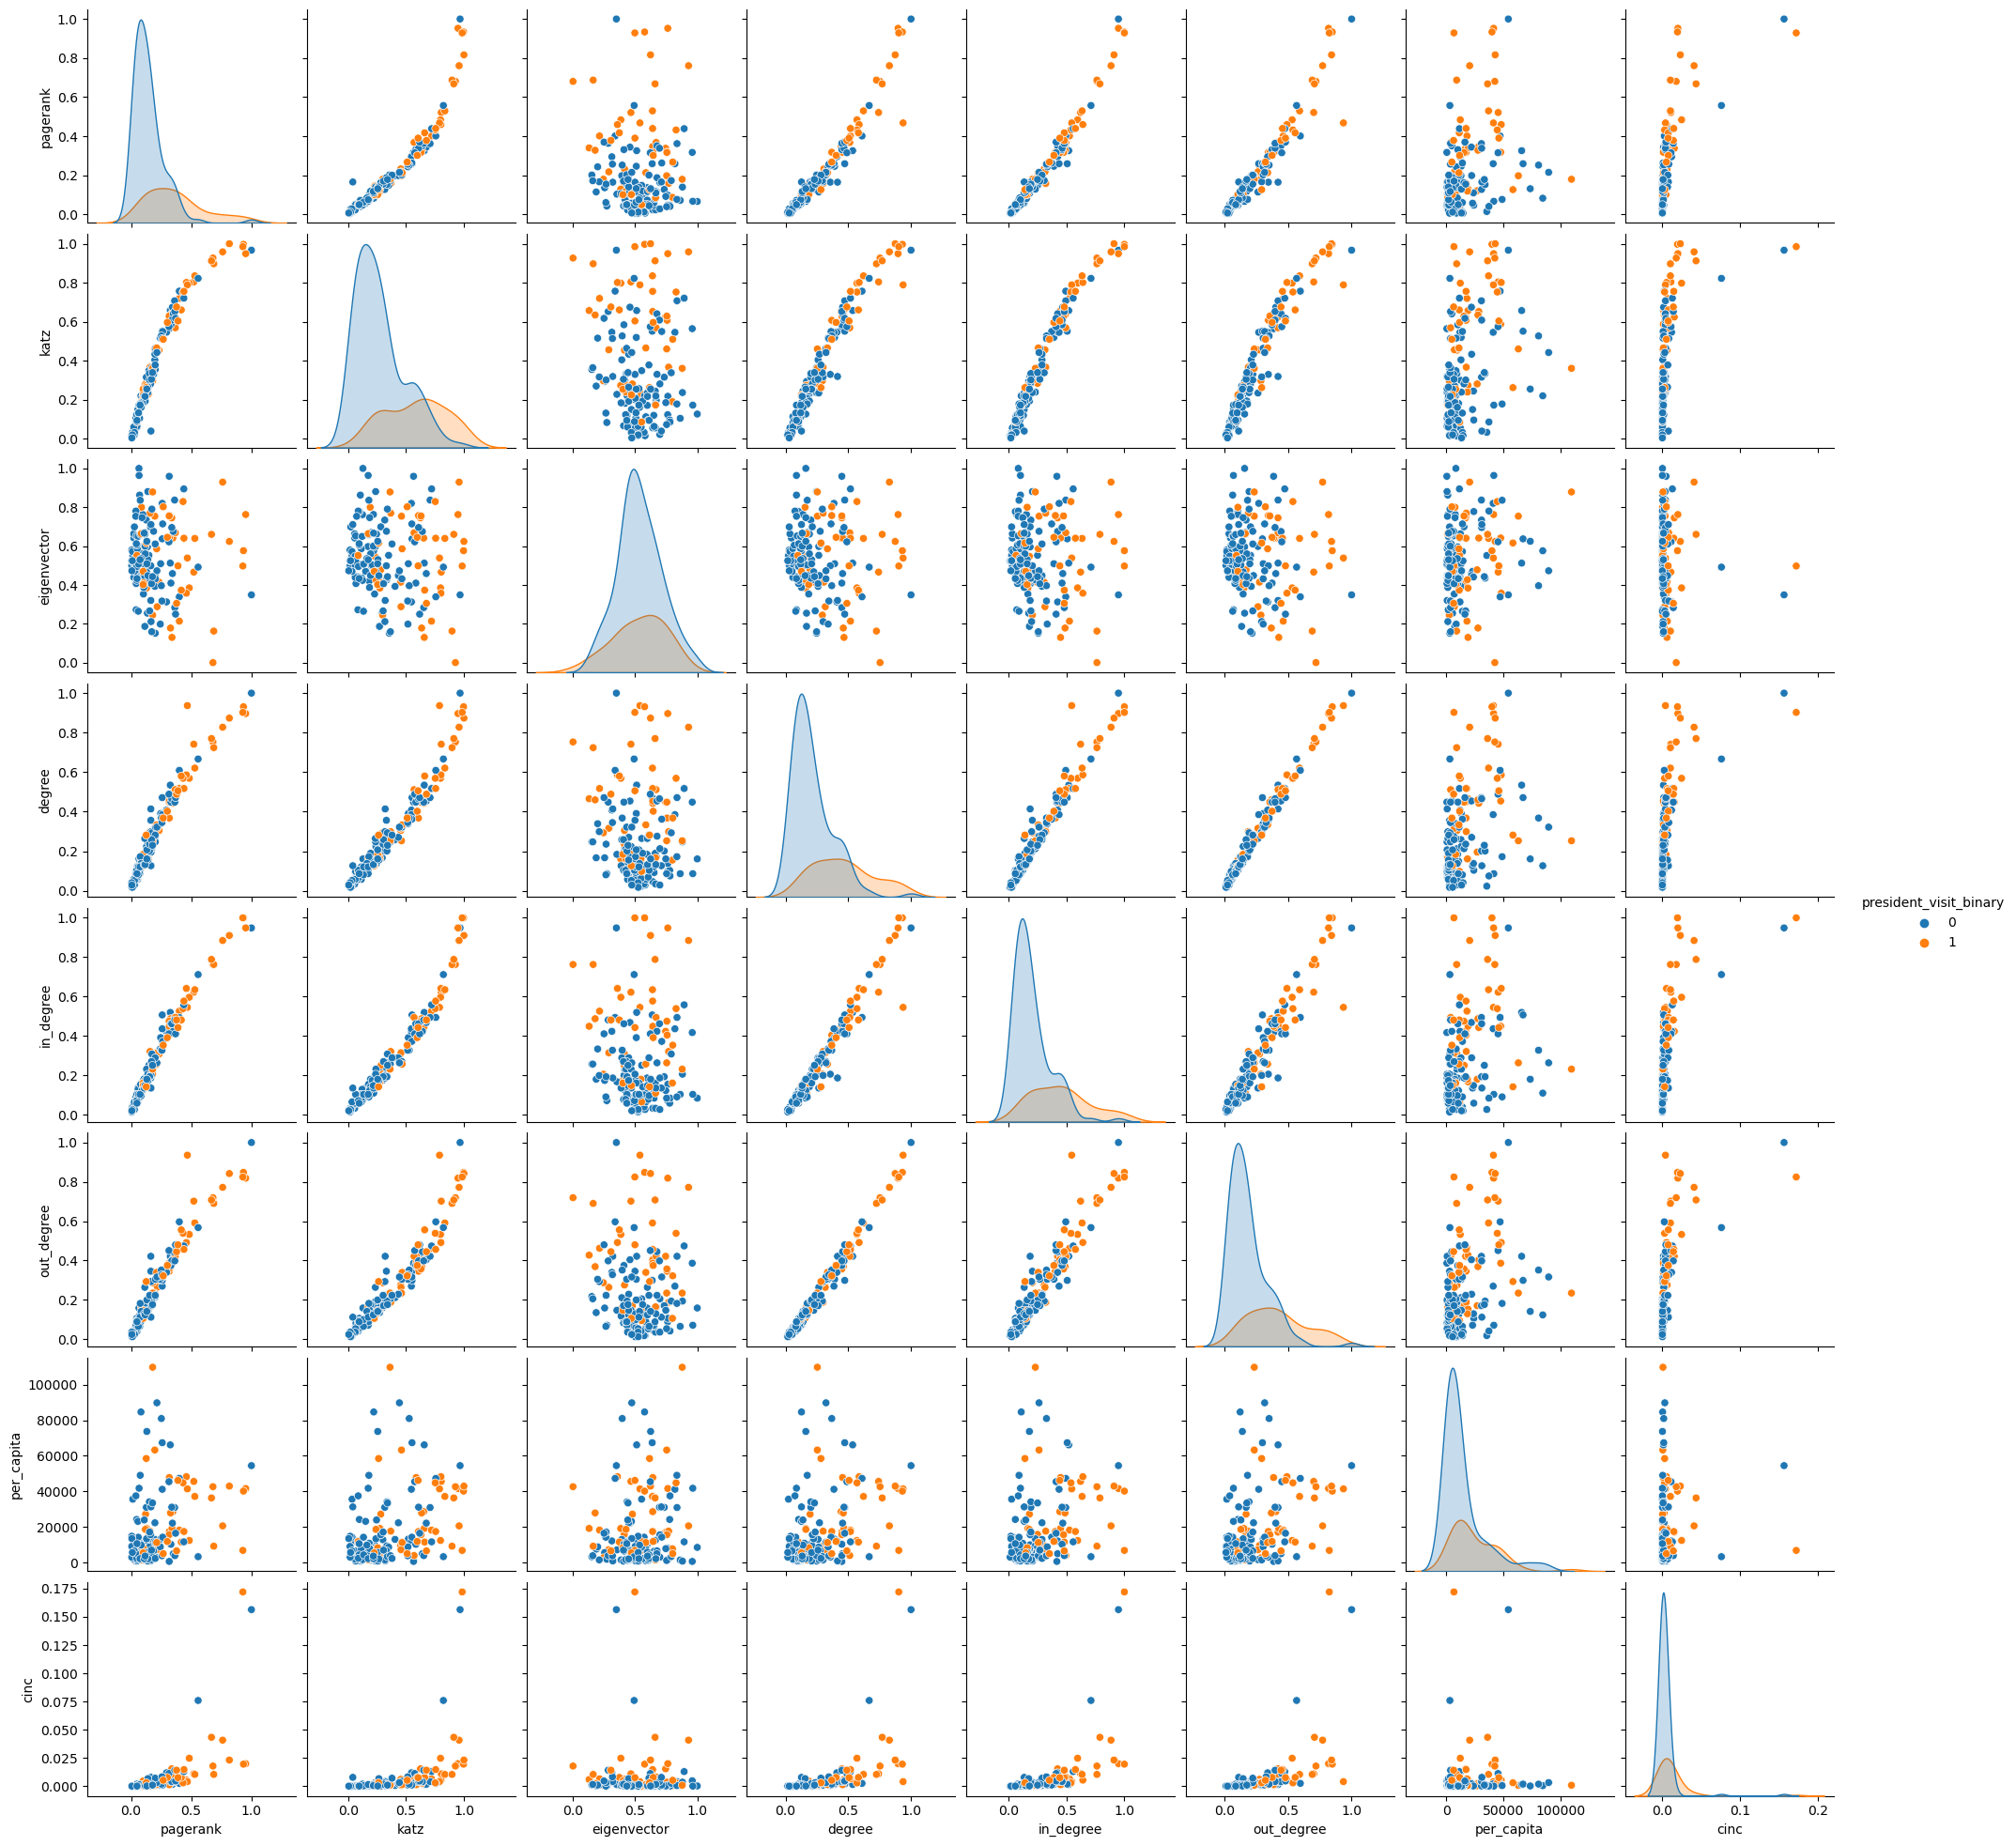

In [12]:
sns.pairplot(data[columns_for_heatmap], hue='president_visit_binary')

## Logistic regression models for each measure separately and per year

In [14]:
import statsmodels.formula.api as smf

In [15]:
# apply logistic regression for year 2005 using each measure and cinc and per_capita variables
measures = ['pagerank', 'katz', 'eigenvector', 'degree', 'in_degree', 'out_degree']
models = []
summaries = []
for measure in measures:
    log_reg = smf.logit(f"president_visit_binary ~ {measure} + cinc + per_capita", data=data).fit()
    models.append(log_reg)
    summaries.append(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.442384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.560485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451720
         Iterations 6


In [16]:
models_per_measure = {}
for year in range(1970,2010,5):
    models_per_measure[year] = {}
    
    data = de.get_data_for_regression(conn, year)
    data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)
    data['per_capita'] = data['rgdpna']/data['pop']
    data = data[data["per_capita"].notna()]
    
    for measure in measures:
        log_reg = smf.logit(f"president_visit_binary ~ {measure} + cinc + per_capita", data=data).fit()
        models_per_measure[year][measure] = log_reg
    

Optimization terminated successfully.
         Current function value: 0.444138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.457703
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430501
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463135
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.327129
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350365
  

In [17]:
for k, val in models_per_measure.items():
    print(str(k)+'\n')
    for measure, model in val.items():
        print(measure)
        print(model.summary())
        print()
    print('*************************************************************************************************************************')
    print('*************************************************************************************************************************')
    print('*************************************************************************************************************************')

1970

pagerank
                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  118
Model:                              Logit   Df Residuals:                      114
Method:                               MLE   Df Model:                            3
Date:                    Sat, 04 Mar 2023   Pseudo R-squ.:                 0.09961
Time:                            14:49:58   Log-Likelihood:                -52.408
converged:                           True   LL-Null:                       -58.206
Covariance Type:                nonrobust   LLR p-value:                  0.008905
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3098      0.421     -5.487      0.000      -3.135      -1.485
pagerank       4.8975      1.729      2.832      0.005       1.508       8.287
cinc 

We observe that all the measures are statistically significant across time except the eigenvector centrality. 
We thus continue modelling excluding eigenvector from our analysis.

In [54]:
# redefine measures
measures = ['pagerank', 'katz', 'in_degree', 'out_degree']

# PCA analysis
We will aggregate all the measures using PCA

In [55]:
# data = de.get_data_for_regression(conn, 2005)

# data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)

# data['per_capita'] = data['rgdpna']/data['pop']

# data = data[data["per_capita"].notna()]

In [56]:
# dataset columns to apply PCA
X = data[measures].values

In [57]:
# eigenvalues and eigenvectors for square matrix
square = np.dot(np.transpose(X),X)
np.linalg.eig(square)

(array([8.22119401e+01, 5.33848623e-02, 6.91418233e-01, 4.06364903e-01]),
 array([[ 0.4004768 , -0.60311363, -0.65390995, -0.21971357],
        [ 0.6248658 , -0.33504746,  0.70420396, -0.03718493],
        [ 0.49153729,  0.67502928, -0.14304636, -0.53128551],
        [ 0.45557892,  0.26140508, -0.23671986,  0.81736096]]))

We can see that the first two eigenvalues are really large compared to the rest. Therefore, we select the first two principal components.

In [58]:
# apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [59]:
# transform data to principal components
X_pca = pca.transform(X)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
pca_df

,PC1,PC2
0,1.389650,0.293459
1,0.783104,0.016458
2,-0.505294,0.037932
3,-0.383134,0.014267
4,-0.192129,0.019323
...,...,...
159,0.189302,-0.049984
160,0.456019,-0.061062
161,0.416056,0.006609
162,-0.068582,-0.027740


In [60]:
# add principal components to dataset
data['PC1'] = pca_df['PC1']
data['PC2'] = pca_df['PC2']

In [61]:
# apply logistic regression for year 2005 using the PC1, PC2, cinc and per_capita variables
import statsmodels.formula.api as smf
log_reg_1 = smf.logit("president_visit_binary ~ PC1 + PC2 + cinc + per_capita", data=data).fit()
print(log_reg_1.summary())

Optimization terminated successfully.
         Current function value: 0.554494
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  148
Model:                              Logit   Df Residuals:                      143
Method:                               MLE   Df Model:                            4
Date:                    Sat, 04 Mar 2023   Pseudo R-squ.:                 0.07041
Time:                            14:56:45   Log-Likelihood:                -82.065
converged:                           True   LL-Null:                       -88.281
Covariance Type:                nonrobust   LLR p-value:                   0.01442
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5535      0.283     -5.495      0.000      -2.108      -0.9

We can see that the coefficient for PC2 is not statistically significant while its value is also small. Therefore we exclude it from our analysis

In [70]:
# apply logistic regression to PC1, cinc and per_capita variables
log_reg_2 = smf.logit("president_visit_binary ~ PC1 + cinc + per_capita", data=data).fit()
print(log_reg_2.summary())

Optimization terminated successfully.
         Current function value: 0.444537
         Iterations 6
                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  164
Model:                              Logit   Df Residuals:                      160
Method:                               MLE   Df Model:                            3
Date:                    Sat, 04 Mar 2023   Pseudo R-squ.:                  0.2579
Time:                            15:00:15   Log-Likelihood:                -72.904
converged:                           True   LL-Null:                       -98.247
Covariance Type:                nonrobust   LLR p-value:                 5.708e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2649      0.288     -4.396      0.000      -1.829      -0.7

We observe that PC1 is statistically significant. We also observe that cinc is also statistically significant while per_capita is not statistically significant. This means that controlling for economic measures of status, our network-based international relations measure plays an important role in predicting a president's visits. Cinc is a variable signifying the political situation in countries which is related to international affairs.

In [63]:
regression_dict = {} 
for name_model1 in list(log_reg_1.params.index):
    regression_dict[f'model1_coef_{name_model1}'] = []
    regression_dict[f'model1_std_{name_model1}'] = []

for name_model2 in list(log_reg_2.params.index):
    regression_dict[f'model2_coef_{name_model2}'] = []
    regression_dict[f'model2_std_{name_model2}'] = []

In [67]:
measures = ['pagerank', 'katz', 'degree', 'in_degree', 'out_degree']
regression_dict = {} 
models_reg1 = []
models_reg2 = []
for i in range(1970,2010,5):
    
    data = de.get_data_for_regression(conn, i)
    
    # Generate dummys
    data['president_visit_binary'] = data['destination country'].map(lambda x: 0 if x is None else 1)
    
    # Extract the columns for PCA
    X = data[measures].values
    
    
    # Fit the principal component
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # Obtain the principal component and assign it to the dataset
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
    data['PC1'] = pca_df['PC1']
    data['PC2'] = pca_df['PC2']
    
    # Generate the economic variable
    data['per_capita'] = data['rgdpna']/data['pop']
    
    # Drop those empty GDP per capita
    data = data[data["per_capita"].notna()]
    
    # Fit the logistic regression
    log_reg_1 = smf.logit("president_visit_binary ~ PC1 + PC2 + cinc + per_capita", data=data).fit()
    log_reg_2 = smf.logit("president_visit_binary ~ PC1 + cinc + per_capita", data=data).fit()
    print(log_reg_2.summary())
    
    for name1 in log_reg_1.params.index:
        regression_dict[f'model1_coef_{name1}'] = regression_dict.get(f'model1_coef_{name1}', []) + [log_reg_1.params[name1]]
        regression_dict[f'model1_std_{name1}'] = regression_dict.get(f'model1_std_{name1}', []) + [log_reg_1.bse[name1]]
    for name2 in log_reg_2.params.index:
        regression_dict[f'model2_coef_{name2}'] = regression_dict.get(f'model2_coef_{name2}', []) + [log_reg_2.params[name2]]
        regression_dict[f'model2_std_{name2}'] = regression_dict.get(f'model2_std_{name2}', []) + [log_reg_2.bse[name2]]
    
    models_reg1.append(log_reg_1)
    models_reg2.append(log_reg_2)

Optimization terminated successfully.
         Current function value: 0.424901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447935
         Iterations 7
                             Logit Regression Results                             
Dep. Variable:     president_visit_binary   No. Observations:                  118
Model:                              Logit   Df Residuals:                      114
Method:                               MLE   Df Model:                            3
Date:                    Sat, 04 Mar 2023   Pseudo R-squ.:                 0.09191
Time:                            14:58:21   Log-Likelihood:                -52.856
converged:                           True   LL-Null:                       -58.206
Covariance Type:                nonrobust   LLR p-value:                   0.01347
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In [68]:
regression_data = pd.DataFrame(regression_dict)
regression_data['year'] = range(1970,2010,5)
regression_data

,model1_coef_Intercept,model1_std_Intercept,model1_coef_PC1,model1_std_PC1,model1_coef_PC2,model1_std_PC2,model1_coef_cinc,model1_std_cinc,model1_coef_per_capita,model1_std_per_capita,model2_coef_Intercept,model2_std_Intercept,model2_coef_PC1,model2_std_PC1,model2_coef_cinc,model2_std_cinc,model2_coef_per_capita,model2_std_per_capita,year
0,-1.415529,0.369419,1.879136,0.660603,6.995167,3.077481,-15.353445,13.732045,-0.000014,0.000031,-1.311640,0.361083,1.795687,0.646687,-8.794408,12.058404,-0.000024,0.000032,1970
1,-2.346191,0.432008,2.848211,0.649324,-9.206228,4.712441,-11.042588,13.487078,0.000012,0.000012,-2.182041,0.391846,2.538009,0.593278,3.499016,13.097144,0.000006,0.000013,1975
2,-2.506812,0.448954,2.877121,0.655180,-4.875223,5.429233,-8.663257,12.721208,0.000009,0.000014,-2.393715,0.413014,2.754450,0.626126,-6.385247,12.462715,0.000005,0.000014,1980
3,-2.586134,0.451970,2.713220,0.733016,-1.938491,4.267467,-9.047240,14.305215,0.000010,0.000017,-2.555495,0.439191,2.713615,0.734670,-10.204345,14.248174,0.000009,0.000016,1985
4,-2.270017,0.417944,3.293554,0.736383,-5.875241,4.317052,-13.679151,12.597830,0.000013,0.000016,-2.143398,0.386205,3.353601,0.749110,-17.148355,12.663573,0.000010,0.000015,1990
5,-2.154959,0.390092,3.770696,0.811612,-0.837369,4.739210,-37.923944,20.236628,0.000023,0.000012,-2.127419,0.354584,3.824459,0.763460,-40.283213,15.572545,0.000023,0.000012,1995
6,-0.602525,0.287957,3.620399,0.757926,-4.689975,5.031866,-21.194168,16.602475,-0.000007,0.000011,-0.489459,0.261890,4.011669,0.695141,-31.935807,12.611336,-0.000006,0.000011,2000
7,-1.275164,0.306775,3.239672,0.654280,-0.418973,4.290706,-23.003569,13.706427,0.000004,0.000010,-1.264907,0.287732,3.262404,0.615596,-23.836351,10.804959,0.000004,0.000010,2005


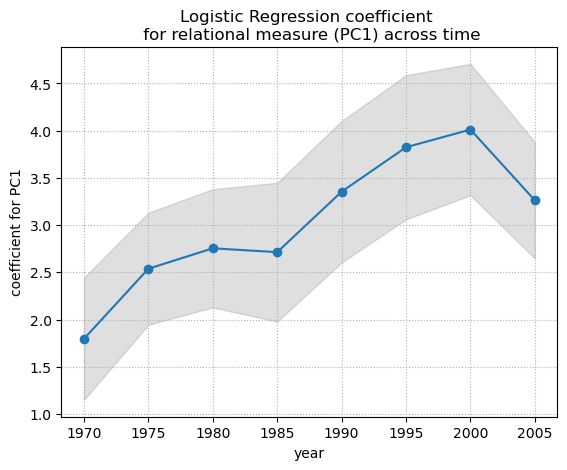

In [69]:
plt.title("Logistic Regression coefficient \n for relational measure (PC1) across time")
plt.ylabel('coefficient for PC1')
plt.xlabel("year")
plt.grid(ls=':')
plt.plot(regression_data['year'], regression_data['model2_coef_PC1'], 'o-')
plt.fill_between(regression_data['year'], regression_data['model2_coef_PC1'] - regression_data['model2_std_PC1'], regression_data['model2_coef_PC1'] + regression_data['model2_std_PC1'], alpha=0.25, color='grey')
plt.savefig('./plots/results/PC1_coef_across_time.png',dpi=300)

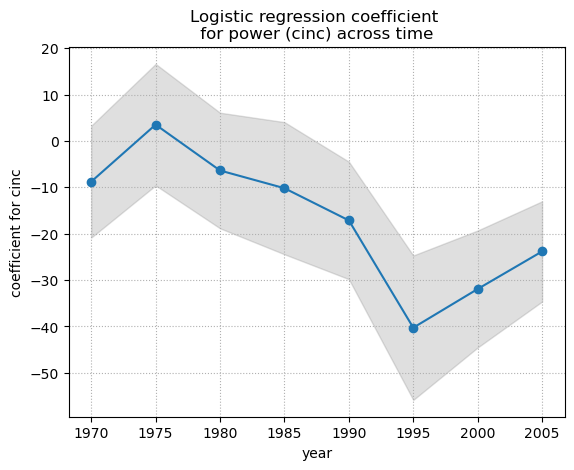

In [59]:
plt.title("Logistic regression coefficient \n for power (cinc) across time ")
plt.ylabel('coefficient for cinc')
plt.xlabel('year')
plt.grid(ls=':')
plt.plot(regression_data['year'], regression_data['model2_coef_cinc'], 'o-')
plt.fill_between(regression_data['year'], regression_data['model2_coef_cinc'] - regression_data['model2_std_cinc'], regression_data['model2_coef_cinc'] + regression_data['model2_std_cinc'], alpha=0.25, color='grey')
plt.savefig('./plots/results/cinc_coef_across_time.png',dpi=300)

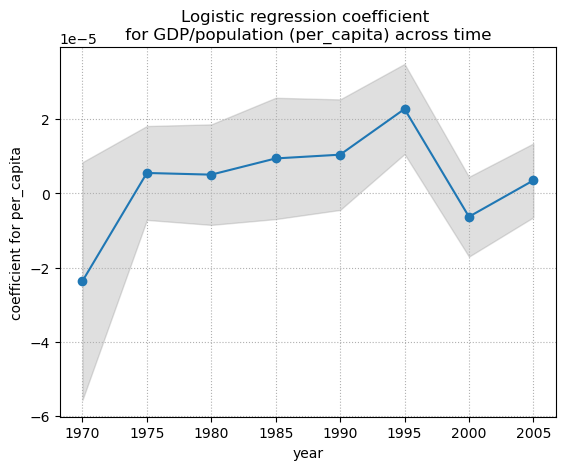

In [60]:
plt.title("Logistic regression coefficient \n for GDP/population (per_capita) across time ")
plt.ylabel('coefficient for per_capita')
plt.xlabel('year')
plt.grid(ls=':')
plt.plot(regression_data['year'], regression_data['model2_coef_per_capita'], 'o-')
plt.fill_between(regression_data['year'], regression_data['model2_coef_per_capita'] - regression_data['model2_std_per_capita'], regression_data['model2_coef_per_capita'] + regression_data['model2_std_per_capita'], alpha=0.25, color='grey')
plt.savefig('./plots/results/per_capita_coef_across_time.png',dpi=300)